**1. Setup**


1.1 Install Dependencies

In [3]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

1.2 Import Dependencies


In [2]:
!pip install testresources

     |████████████████████████████████| 112 kB 4.5 MB/s eta 0:00:01


In [1]:
#Import Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import TensorFlow Dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

2022-05-30 16:51:26.924572: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


1.3 Set GPU Growth

In [4]:
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

1.4 Create Folder Structures

In [5]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

**2. Collect Positives and Anchors**

2.1 Untar labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [11]:
# Uncompress Tar GZ 
!tar -xf lfw.tgz

In [12]:
# Move LFW images to data-neg repo
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    EX_PATH = os.path.join('lfw',directory,file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH,NEW_PATH)

2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid lib to generate unique image names
import uuid

In [8]:
uuid.uuid1()

UUID('ea6f86a8-dd28-11ec-bd3e-4361ceb1bd4d')

In [9]:
cap = cv2.VideoCapture(0) # Establish  a connection to the cam
while cap.isOpened():
  ret, frame = cap.read()

  frame = frame[120:120+250,200:200+250,:] # Cut down frame to 250x250
    
  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
        # create a unique filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor img
        cv2.imwrite(imgname, frame)

  # Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
        # create a unique filepath
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out positive img
        cv2.imwrite(imgname, frame)
        
        
  cv2.imshow('Image Collection', frame) # Show image back to screen

  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

cap.release() # Release the cam
cv2.destroyAllWindows()  # Close the image show frame

**2. NEw = Data Augmentation**

In [7]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
        
    return data

In [9]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

2022-05-30 17:12:10.313315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 17:12:10.336426: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-30 17:12:10.336518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-30 17:12:10.336536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


In [11]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

**3. Load and Preprocess Images**

3.1 Get Image Dir

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data/anchor/8c076d5c-e00d-11ec-9f29-af70390a0bc4.jpg'

3.2 Preprocessing- Scale and Resize

In [16]:
def preprocess(file_path):
    # read in img from file path
    byte_img = tf.io.read_file(file_path)
    # load in the img
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the img to 100x100
    img = tf.image.resize(img, (100,100))
    # scale image between 1 & 0
    img = img/255.0
    return img

In [13]:
img = preprocess(b'data/anchor/9931150e-dd26-11ec-bd3e-4361ceb1bd4d.jpg')

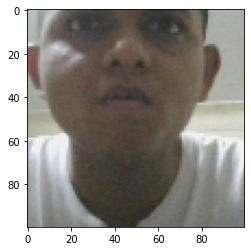

In [14]:
plt.imshow(img)

In [17]:
img.numpy().min()

0.13406862

In [18]:
img.numpy().max()

0.9723039

3.3 Create Labelled dataset

In [17]:
# (anchor,+ve) --> 1,1,1,1,1
# (anchor,-ve) --> 0,0,0,0,0
tf.ones_like([1,1,1,4.322,2345])

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [30]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [31]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [20]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [21]:
iterator_labs = class_labels.as_numpy_iterator()

In [22]:
iterator_labs.next()

0.0

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data/anchor/8c076e0c-e00d-11ec-9f29-af70390a0bc4.jpg',
 b'data/positive/b8dbdfb0-e00d-11ec-9f29-af70390a0bc4.jpg',
 1.0)

3.4 Build Train and test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*example)

In [28]:
len(res)

3

In [45]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.61495095, 0.63848037, 0.6227941 ],
        [0.62352943, 0.64705884, 0.6313726 ],
        [0.62941176, 0.65294117, 0.6372549 ],
        ...,
        [0.56911767, 0.60833335, 0.57303923],
        [0.5612745 , 0.6004902 , 0.5593137 ],
        [0.5715686 , 0.60294116, 0.5598039 ]],

       [[0.61691177, 0.64142156, 0.6227941 ],
        [0.6252451 , 0.6504902 , 0.63161767],
        [0.61151963, 0.6389706 , 0.6193628 ],
        ...,
        [0.5654412 , 0.59093136, 0.5634804 ],
        [0.5588235 , 0.5872549 , 0.5480392 ],
        [0.5647059 , 0.59411764, 0.55196077]],

       [[0.6262255 , 0.6625    , 0.62916666],
        [0.61789215, 0.654902  , 0.6213235 ],
        [0.6186274 , 0.6578431 , 0.6257353 ],
        ...,
        [0.5686275 , 0.5801471 , 0.55784315],
        [0.56789213, 0.58235294, 0.5482843 ],
        [0.5745098 , 0.5892157 , 0.5529412 ]],

       ...,

       [[0.5156863 , 0.5392157 , 0.53333336],
        [0.50

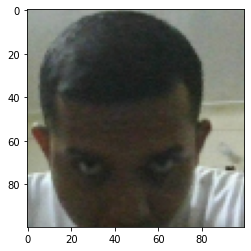

In [46]:
plt.imshow(res[0])

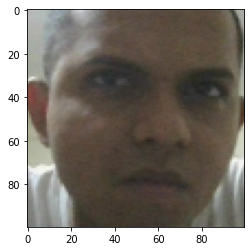

In [47]:
plt.imshow(res[1])

In [48]:
res[2]

1.0

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [30]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [31]:
samples = data.as_numpy_iterator()

In [32]:
samp = samples.next()

2022-05-30 17:18:29.775954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-30 17:18:29.931348: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2022-05-30 17:18:39.778874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3468 of 10000
2022-05-30 17:18:49.812304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4095 of 10000
2022-05-30 17:18:59.779757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4729 of 10000
2022-05-30 17:19:09.778180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5351 of 10000
2022-05-30 17:19:19.788734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may ta

In [60]:
len(samples.next())

3

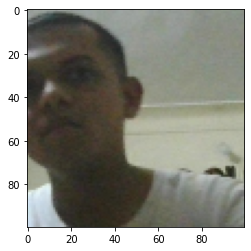

In [61]:
plt.imshow(samp[0])

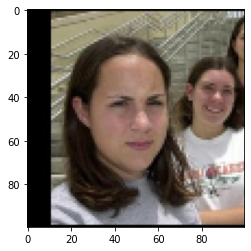

In [62]:
plt.imshow(samp[1])

In [63]:
samp[2]

0.0

In [33]:
# Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [34]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [66]:
train_samples = train_data.as_numpy_iterator()

In [67]:
train_sample = train_samples.next()

In [68]:
len(train_sample[0])

16

In [35]:
# testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [71]:
round(len(data)*.7)

420

In [72]:
round(len(data)*.3)

180

**4. Model Engineering**

4.1 Build Embedding Layer

In [36]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
inp = Input(shape=(100,100,3), name='input_image')

In [40]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [41]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [42]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [43]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [44]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [93]:
6*6*256

9216

In [94]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [95]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [45]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

4.2 Build Distance Layer

In [49]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embbedding):
        return tf.math.abs(input_embedding - validation_embbedding)

In [50]:
l1 = L1Dist()

In [105]:
l1 #l1(anchor_embedding, validation_embedding)

4.3 Make Siamese Model

In [51]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image input in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
                             
    # Combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')
    

In [53]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [54]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [55]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [56]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [57]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

In [58]:
classifier = Dense(1, activation='sigmoid')(distances)

In [59]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [60]:
siamese_network = Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [61]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [62]:
siamese_model = make_siamese_model()

In [63]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

**5. Training**

5.1 Setup Loss and Optimizer

In [64]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [65]:
opt = tf.keras.optimizers.Adam(1e-4) 

5.2 Establish Checkpoints

In [66]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [126]:
test_batch = train_data.as_numpy_iterator()

In [128]:
batch1 = test_batch.next()

In [129]:
len(batch1)

3

In [131]:
len(batch1[0])

16

In [132]:
len(batch1[1])

16

In [136]:
y = batch1[2]

In [137]:
y

array([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [134]:
X = batch1[:2]

In [135]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [67]:
@tf.function
def train_step(batch):
    
    # record all of our operations
    with tf.GradientTape() as tape:
        
        # Get anchor and =ve/-ve img
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y,yhat)
        
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

5.4 Build Training Loop

In [69]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
 30/263 [==>...........................] - ETA: 26:45

KeyboardInterrupt: 

**6. Evaluate the Model**

6.1 Import Metrics

In [148]:
# Import metric calculations
from tensorflow.keras.metrics import Precision,Recall

6.2 Make Predictions

In [149]:
# Get a batch of test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [151]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [9.9999976e-01],
       [9.9994791e-01],
       [2.8785442e-05],
       [9.9999869e-01],
       [1.0000000e+00],
       [9.9979788e-01],
       [1.0000000e+00],
       [5.1766870e-07],
       [9.9910295e-01],
       [5.5571199e-08],
       [3.9932740e-05],
       [9.9999475e-01],
       [9.9980032e-01],
       [9.9770004e-01],
       [4.6323933e-07]], dtype=float32)

In [152]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]

In [153]:
y_true

array([1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

6.3 Calculating Metrics

In [154]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [155]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

6.4 Visualizing Results

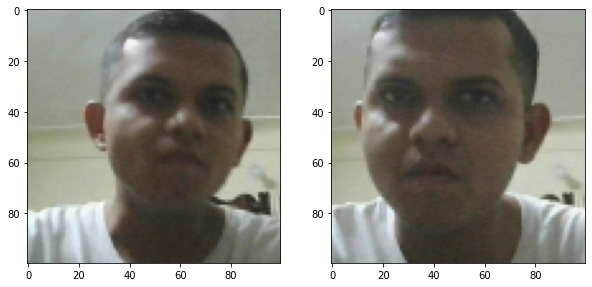

In [159]:
# set plot size
plt.figure(figsize=(10,8))
# set first sublot
plt.subplot(1,2,1)
plt.imshow(test_input[1])
# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

**7. Save Model**

In [160]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [163]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [164]:
# make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [9.9999976e-01],
       [9.9994791e-01],
       [2.8785442e-05],
       [9.9999869e-01],
       [1.0000000e+00],
       [9.9979788e-01],
       [1.0000000e+00],
       [5.1766870e-07],
       [9.9910295e-01],
       [5.5571199e-08],
       [3.9932740e-05],
       [9.9999475e-01],
       [9.9980032e-01],
       [9.9770004e-01],
       [4.6323933e-07]], dtype=float32)

In [165]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

**8. Real Time test**

8.1 Verification Function

In [171]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion os positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified
 

8.2 OpenCV Real Time Verification

In [175]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

In [172]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     